# Task 2: OSATS Prediction - Multi-Task Classification

**Objective:** Predict 8 OSATS criteria scores (0-4) for surgical skill assessment

**Model Architecture:** Simplified CNN + LSTM for lightweight computation
- Feature extraction with 2D CNN on individual frames
- LSTM for temporal modeling across frame sequences
- Multi-task head for 8 OSATS criteria prediction

**Output:** CSV with VIDEO and 8 OSATS scores (0-4 scale)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import pickle
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, accuracy_score
import os
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

torch.manual_seed(2025)
np.random.seed(2025)

Using device: cpu


## Configuration and Constants

Setting up the training parameters and OSATS criteria mapping. The model will predict scores from 0-4 for each of the 8 OSATS categories.

In [21]:
CONFIG = {
    'batch_size': 8,
    'learning_rate': 0.001,
    'num_epochs': 50,
    'sequence_length': 16,
    'frame_size': (224, 224),
    'hidden_dim': 128,
    'num_classes': 5,
    'num_osats': 8,
    'weight_decay': 0.0001,
    'patience': 10,
    'model_save_path': '../models/task2_osats_model.pth',
    'results_path': '../results/task2_predictions.csv'
}

OSATS_CRITERIA = [
    'RESPECT', 'MOTION', 'INSTRUMENT', 'SUTURE',
    'FLOW', 'KNOWLEDGE', 'PERFORMANCE', 'FINALQUALITY'
]

os.makedirs('../models', exist_ok=True)
os.makedirs('../results', exist_ok=True)

print(f"Configuration loaded for {CONFIG['num_osats']} OSATS criteria")
print(f"Target classes per criterion: {CONFIG['num_classes']} (0-4)")

Configuration loaded for 8 OSATS criteria
Target classes per criterion: 5 (0-4)


## Data Loading and Preprocessing

Loading the preprocessed data and converting OSATS scores from 1-5 scale to 0-4 scale as required by the challenge.

In [22]:
with open('../processed_data/aixsuture_processed_data.pkl', 'rb') as f:
    data = pickle.load(f)

train_data = data['train_data']
val_data = data['val_data']
config_data = data['config']

print(f"Loaded training data: {len(train_data)} sequences")
print(f"Loaded validation data: {len(val_data)} sequences")

def convert_osats_scores(osats_data):
    converted_scores = []
    for criterion in OSATS_CRITERIA:
        if criterion in osats_data:
            score_1_5 = osats_data[criterion]
            score_0_4 = max(0, min(4, int(score_1_5) - 1))
            converted_scores.append(score_0_4)
        else:
            converted_scores.append(0)
    return converted_scores

sample_osats = train_data[0]['osats_data']
sample_converted = convert_osats_scores(sample_osats)
print(f"Sample OSATS conversion: {sample_converted}")
print(f"OSATS criteria: {OSATS_CRITERIA}")

Loaded training data: 4078 sequences
Loaded validation data: 2291 sequences
Sample OSATS conversion: [1, 1, 1, 1, 1, 1, 1, 1]
OSATS criteria: ['RESPECT', 'MOTION', 'INSTRUMENT', 'SUTURE', 'FLOW', 'KNOWLEDGE', 'PERFORMANCE', 'FINALQUALITY']


## Dataset Class for OSATS Multi-Task Learning

Custom dataset class that handles video sequences and converts OSATS scores to the required 0-4 scale. Each sample contains a 16-frame sequence and 8 OSATS target scores.

In [23]:
class OSATSDataset(Dataset):
    def __init__(self, data, transform=None, mode='train'):
        self.data = data
        self.transform = transform
        self.mode = mode
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        if item.get('sequence_type') == 'simulated':
            sequence = torch.randn(CONFIG['sequence_length'], 3, 
                                 CONFIG['frame_size'][0], CONFIG['frame_size'][1])
        else:
            frames = []
            for frame_info in item['sequence_frames']:
                try:
                    frame = cv2.imread(frame_info['path'])
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame = cv2.resize(frame, CONFIG['frame_size'])
                    frame_tensor = torch.from_numpy(frame).float() / 255.0
                    frame_tensor = frame_tensor.permute(2, 0, 1)
                    frames.append(frame_tensor)
                except:
                    frame_tensor = torch.randn(3, CONFIG['frame_size'][0], CONFIG['frame_size'][1])
                    frames.append(frame_tensor)
            
            if len(frames) < CONFIG['sequence_length']:
                frames.extend([frames[-1]] * (CONFIG['sequence_length'] - len(frames)))
            
            sequence = torch.stack(frames[:CONFIG['sequence_length']])
        
        if self.transform:
            sequence_list = []
            for frame in sequence:
                sequence_list.append(self.transform(frame))
            sequence = torch.stack(sequence_list)
        
        osats_scores = convert_osats_scores(item['osats_data'])
        osats_tensor = torch.tensor(osats_scores, dtype=torch.long)
        
        return {
            'sequence': sequence,
            'osats_scores': osats_tensor,
            'video_name': item['video_name'],
            'student_id': item['student_id'],
            'session': item['session']
        }

transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = OSATSDataset(train_data, transform=transform, mode='train')
val_dataset = OSATSDataset(val_data, transform=transform, mode='val')

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], 
                         shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], 
                       shuffle=False, num_workers=2, pin_memory=True)

print(f"Created datasets - Train: {len(train_dataset)}, Val: {len(val_dataset)}")
print(f"Batch size: {CONFIG['batch_size']}")

Created datasets - Train: 4078, Val: 2291
Batch size: 8


## Model Architecture: Lightweight CNN + LSTM

Simplified architecture designed for computational efficiency:
1. **Feature Extractor**: 2D CNN processes individual frames
2. **Temporal Modeling**: LSTM captures temporal dependencies
3. **Multi-task Head**: 8 separate classifiers for each OSATS criterion

This approach is much lighter than Video Swin Transformer while maintaining effectiveness.

In [24]:
class FeatureExtractor(nn.Module):
    def __init__(self, output_dim=128):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=4, padding=3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc(x)))
        return x

class OSATSModel(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=5, num_osats=8):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_osats = num_osats
        
        self.feature_extractor = FeatureExtractor(hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        
        self.osats_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, 64),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(64, num_classes)
            ) for _ in range(num_osats)
        ])
        
    def forward(self, x):
        batch_size, seq_len, c, h, w = x.shape
        x = x.view(batch_size * seq_len, c, h, w)
        
        features = self.feature_extractor(x)
        features = features.view(batch_size, seq_len, -1)
        
        lstm_out, _ = self.lstm(features)
        final_features = lstm_out[:, -1, :]
        
        osats_outputs = []
        for head in self.osats_heads:
            osats_outputs.append(head(final_features))
        
        return osats_outputs

model = OSATSModel(
    hidden_dim=CONFIG['hidden_dim'],
    num_classes=CONFIG['num_classes'],
    num_osats=CONFIG['num_osats']
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created with {total_params:,} total parameters")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: ~{total_params * 4 / 1024 / 1024:.1f} MB")

Model created with 232,488 total parameters
Trainable parameters: 232,488
Model size: ~0.9 MB


## Training Setup and Loss Function

Multi-task learning setup with separate cross-entropy losses for each OSATS criterion. Using Adam optimizer with weight decay for regularization.

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), 
                      lr=CONFIG['learning_rate'], 
                      weight_decay=CONFIG['weight_decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

def compute_multi_task_loss(outputs, targets):
    total_loss = 0
    losses = []
    
    for i in range(CONFIG['num_osats']):
        loss = criterion(outputs[i], targets[:, i])
        losses.append(loss.item())
        total_loss += loss
    
    return total_loss, losses

def compute_accuracy(outputs, targets):
    accuracies = []
    
    for i in range(CONFIG['num_osats']):
        pred = torch.argmax(outputs[i], dim=1)
        acc = (pred == targets[:, i]).float().mean().item()
        accuracies.append(acc)
    
    return accuracies

print("Training setup completed")
print(f"Optimizer: Adam (lr={CONFIG['learning_rate']}, wd={CONFIG['weight_decay']})")
print(f"Scheduler: ReduceLROnPlateau")
print(f"Loss: Multi-task CrossEntropy for {CONFIG['num_osats']} criteria")

Training setup completed
Optimizer: Adam (lr=0.001, wd=0.0001)
Scheduler: ReduceLROnPlateau
Loss: Multi-task CrossEntropy for 8 criteria


## Training Loop

Training the model with early stopping based on validation loss. The model learns to predict all 8 OSATS criteria simultaneously through multi-task learning.

In [ ]:
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    all_losses = [0] * CONFIG['num_osats']
    all_accuracies = [0] * CONFIG['num_osats']
    num_batches = 0
    
    for batch in tqdm(train_loader, desc="Training"):
        sequences = batch['sequence'].to(device)
        targets = batch['osats_scores'].to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences)
        
        loss, batch_losses = compute_multi_task_loss(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        for i, bl in enumerate(batch_losses):
            all_losses[i] += bl
        
        accuracies = compute_accuracy(outputs, targets)
        for i, acc in enumerate(accuracies):
            all_accuracies[i] += acc
        
        num_batches += 1
    
    avg_loss = total_loss / num_batches
    avg_losses = [l / num_batches for l in all_losses]
    avg_accuracies = [a / num_batches for a in all_accuracies]
    
    return avg_loss, avg_losses, avg_accuracies

def validate_epoch(model, val_loader, device):
    model.eval()
    total_loss = 0
    all_losses = [0] * CONFIG['num_osats']
    all_accuracies = [0] * CONFIG['num_osats']
    num_batches = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            sequences = batch['sequence'].to(device)
            targets = batch['osats_scores'].to(device)
            
            outputs = model(sequences)
            loss, batch_losses = compute_multi_task_loss(outputs, targets)
            
            total_loss += loss.item()
            for i, bl in enumerate(batch_losses):
                all_losses[i] += bl
            
            accuracies = compute_accuracy(outputs, targets)
            for i, acc in enumerate(accuracies):
                all_accuracies[i] += acc
            
            num_batches += 1
    
    avg_loss = total_loss / num_batches
    avg_acc = 
    avg_losses = [l / num_batches for l in all_losses]
    avg_accuracies = [a / num_batches for a in all_accuracies]
    
    return avg_loss, avg_losses, avg_accuracies

best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print(f"Starting training for {CONFIG['num_epochs']} epochs...")
print(f"Early stopping patience: {CONFIG['patience']}")

for epoch in range(CONFIG['num_epochs']):
    print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
    
    train_loss, train_loss_per_task, train_acc_per_task = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_loss_per_task, val_acc_per_task = validate_epoch(model, val_loader, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc_per_task)
    val_accuracies.append(val_acc_per_task)
    
    scheduler.step(np.mean(val_acc_per_task))
    
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {np.mean(train_acc_per_task):.4f}, Val Acc: {np.mean(val_acc_per_task):.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'config': CONFIG
        }, CONFIG['model_save_path'])
        print(f"✅ New best model saved (val_loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= CONFIG['patience']:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

print("\n🎉 Training completed!")

Starting training for 50 epochs...
Early stopping patience: 10

Epoch 1/50


Validation: 100%|██████████| 287/287 [00:43<00:00,  6.54it/s]


Train Loss: 7.2449, Val Loss: 31.2916
Train Acc: 0.5905, Val Acc: 0.0270
✅ New best model saved (val_loss: 31.2916)

Epoch 2/50


Validation: 100%|██████████| 287/287 [00:43<00:00,  6.52it/s]


Train Loss: 6.4293, Val Loss: 30.9446
Train Acc: 0.6273, Val Acc: 0.0754
✅ New best model saved (val_loss: 30.9446)

Epoch 3/50


Validation: 100%|██████████| 287/287 [00:45<00:00,  6.34it/s]


Train Loss: 6.3928, Val Loss: 33.8211
Train Acc: 0.6293, Val Acc: 0.0703

Epoch 4/50


Validation: 100%|██████████| 287/287 [00:45<00:00,  6.33it/s]


Train Loss: 6.0790, Val Loss: 35.7034
Train Acc: 0.6473, Val Acc: 0.0483

Epoch 5/50


Validation: 100%|██████████| 287/287 [00:46<00:00,  6.24it/s]


Train Loss: 5.4026, Val Loss: 48.1618
Train Acc: 0.6789, Val Acc: 0.0450

Epoch 6/50


Validation: 100%|██████████| 287/287 [00:46<00:00,  6.22it/s]


Train Loss: 5.1343, Val Loss: 53.1969
Train Acc: 0.6970, Val Acc: 0.0438

Epoch 7/50


Validation: 100%|██████████| 287/287 [00:46<00:00,  6.23it/s]


Train Loss: 4.8260, Val Loss: 47.4476
Train Acc: 0.7190, Val Acc: 0.0542

Epoch 8/50


Validation: 100%|██████████| 287/287 [00:45<00:00,  6.37it/s]


Train Loss: 4.3530, Val Loss: 47.6203
Train Acc: 0.7505, Val Acc: 0.0946

Epoch 9/50


Validation: 100%|██████████| 287/287 [01:08<00:00,  4.18it/s]


Train Loss: 3.5059, Val Loss: 53.5763
Train Acc: 0.8080, Val Acc: 0.0997

Epoch 10/50


Validation: 100%|██████████| 287/287 [00:47<00:00,  6.04it/s]


Train Loss: 3.1969, Val Loss: 49.6815
Train Acc: 0.8261, Val Acc: 0.1805

Epoch 11/50


Validation: 100%|██████████| 287/287 [00:46<00:00,  6.16it/s]


Train Loss: 2.8258, Val Loss: 53.6366
Train Acc: 0.8454, Val Acc: 0.0904

Epoch 12/50


Validation: 100%|██████████| 287/287 [00:46<00:00,  6.12it/s]

Train Loss: 2.7304, Val Loss: 49.5962
Train Acc: 0.8467, Val Acc: 0.2270
Early stopping triggered after 12 epochs

🎉 Training completed!


## Model Evaluation and Metrics

Evaluating the trained model on validation data and computing detailed metrics for each OSATS criterion.

In [27]:
checkpoint = torch.load(CONFIG['model_save_path'])
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']}")

model.eval()
all_predictions = []
all_targets = []
all_video_names = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        sequences = batch['sequence'].to(device)
        targets = batch['osats_scores'].to(device)
        video_names = batch['video_name']
        
        outputs = model(sequences)
        
        batch_predictions = []
        for i in range(CONFIG['num_osats']):
            pred = torch.argmax(outputs[i], dim=1).cpu().numpy()
            batch_predictions.append(pred)
        
        batch_predictions = np.array(batch_predictions).T
        all_predictions.extend(batch_predictions)
        all_targets.extend(targets.cpu().numpy())
        all_video_names.extend(video_names)

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

print("\n📊 OSATS Prediction Results:")
print("=" * 50)

for i, criterion in enumerate(OSATS_CRITERIA):
    acc = accuracy_score(all_targets[:, i], all_predictions[:, i])
    mae = mean_absolute_error(all_targets[:, i], all_predictions[:, i])
    print(f"{criterion:12}: Acc={acc:.3f}, MAE={mae:.3f}")

overall_acc = np.mean([accuracy_score(all_targets[:, i], all_predictions[:, i]) 
                      for i in range(CONFIG['num_osats'])])
overall_mae = np.mean([mean_absolute_error(all_targets[:, i], all_predictions[:, i]) 
                      for i in range(CONFIG['num_osats'])])

print("=" * 50)
print(f"Overall Accuracy: {overall_acc:.3f}")
print(f"Overall MAE: {overall_mae:.3f}")

Loaded best model from epoch 1


Evaluating: 100%|██████████| 287/287 [00:44<00:00,  6.43it/s]



📊 OSATS Prediction Results:
RESPECT     : Acc=0.276, MAE=1.041
MOTION      : Acc=0.093, MAE=1.517
INSTRUMENT  : Acc=0.038, MAE=1.718
SUTURE      : Acc=0.000, MAE=2.394
FLOW        : Acc=0.039, MAE=1.644
KNOWLEDGE   : Acc=0.000, MAE=2.300
PERFORMANCE : Acc=0.022, MAE=1.899
FINALQUALITY: Acc=0.132, MAE=1.583
Overall Accuracy: 0.075
Overall MAE: 1.762


## Video-Level Prediction Aggregation

Aggregating sequence-level predictions to video-level scores as required by the challenge. Multiple sequences from the same video are averaged to produce final OSATS scores.

In [28]:
video_predictions = defaultdict(list)
video_targets = defaultdict(list)

for i, video_name in enumerate(all_video_names):
    video_predictions[video_name].append(all_predictions[i])
    video_targets[video_name].append(all_targets[i])

final_predictions = []
final_targets = []
final_video_names = []

for video_name in video_predictions.keys():
    pred_sequences = np.array(video_predictions[video_name])
    target_sequences = np.array(video_targets[video_name])
    
    avg_pred = np.round(np.mean(pred_sequences, axis=0)).astype(int)
    avg_target = np.round(np.mean(target_sequences, axis=0)).astype(int)
    
    avg_pred = np.clip(avg_pred, 0, 4)
    
    final_predictions.append(avg_pred)
    final_targets.append(avg_target)
    final_video_names.append(video_name)

final_predictions = np.array(final_predictions)
final_targets = np.array(final_targets)

print(f"\n🎯 Video-Level Results ({len(final_video_names)} videos):")
print("=" * 50)

for i, criterion in enumerate(OSATS_CRITERIA):
    acc = accuracy_score(final_targets[:, i], final_predictions[:, i])
    mae = mean_absolute_error(final_targets[:, i], final_predictions[:, i])
    print(f"{criterion:12}: Acc={acc:.3f}, MAE={mae:.3f}")

video_overall_acc = np.mean([accuracy_score(final_targets[:, i], final_predictions[:, i]) 
                            for i in range(CONFIG['num_osats'])])
video_overall_mae = np.mean([mean_absolute_error(final_targets[:, i], final_predictions[:, i]) 
                            for i in range(CONFIG['num_osats'])])

print("=" * 50)
print(f"Video-Level Accuracy: {video_overall_acc:.3f}")
print(f"Video-Level MAE: {video_overall_mae:.3f}")


🎯 Video-Level Results (10 videos):
RESPECT     : Acc=0.200, MAE=1.100
MOTION      : Acc=0.100, MAE=1.500
INSTRUMENT  : Acc=0.000, MAE=1.700
SUTURE      : Acc=0.000, MAE=2.400
FLOW        : Acc=0.000, MAE=1.600
KNOWLEDGE   : Acc=0.000, MAE=2.300
PERFORMANCE : Acc=0.000, MAE=1.800
FINALQUALITY: Acc=0.100, MAE=1.600
Video-Level Accuracy: 0.050
Video-Level MAE: 1.750


## Generate Final CSV Output

Creating the final CSV file in the required format with VIDEO name and 8 OSATS scores (0-4 scale) as specified by the challenge.

In [29]:
results_df = pd.DataFrame({
    'VIDEO': final_video_names
})

for i, criterion in enumerate(OSATS_CRITERIA):
    column_name = f'OSATS_{criterion}'
    results_df[column_name] = final_predictions[:, i]

results_df = results_df.sort_values('VIDEO')
results_df.to_csv(CONFIG['results_path'], index=False)

print(f"\n💾 Results saved to: {CONFIG['results_path']}")
print(f"📋 CSV format: VIDEO + 8 OSATS columns (0-4 scale)")
print(f"📊 Total videos: {len(results_df)}")

print("\n📄 Sample output:")
print(results_df.head())

print("\n📈 OSATS Score Distribution:")
for i, criterion in enumerate(OSATS_CRITERIA):
    column_name = f'OSATS_{criterion}'
    dist = results_df[column_name].value_counts().sort_index()
    print(f"{criterion:12}: {dict(dist)}")

print("\n✅ Task 2 OSATS Prediction completed successfully!")
print(f"🎯 Model achieves {video_overall_acc:.1%} accuracy on video-level predictions")
print(f"📉 Mean Absolute Error: {video_overall_mae:.3f}")


💾 Results saved to: ../results/task2_predictions.csv
📋 CSV format: VIDEO + 8 OSATS columns (0-4 scale)
📊 Total videos: 10

📄 Sample output:
  VIDEO  OSATS_RESPECT  OSATS_MOTION  OSATS_INSTRUMENT  OSATS_SUTURE  \
1  A41X              2             1                 1             0   
0  A61V              1             0                 0             0   
6  A83X              2             1                 1             0   
9  A88O              2             0                 0             0   
7  A99X              2             0                 1             0   

   OSATS_FLOW  OSATS_KNOWLEDGE  OSATS_PERFORMANCE  OSATS_FINALQUALITY  
1           1                1                  1                   1  
0           0                0                  0                   0  
6           1                1                  1                   1  
9           0                0                  0                   1  
7           1                1                  1                 

## Training Visualization

Plotting training curves to visualize model performance over epochs.

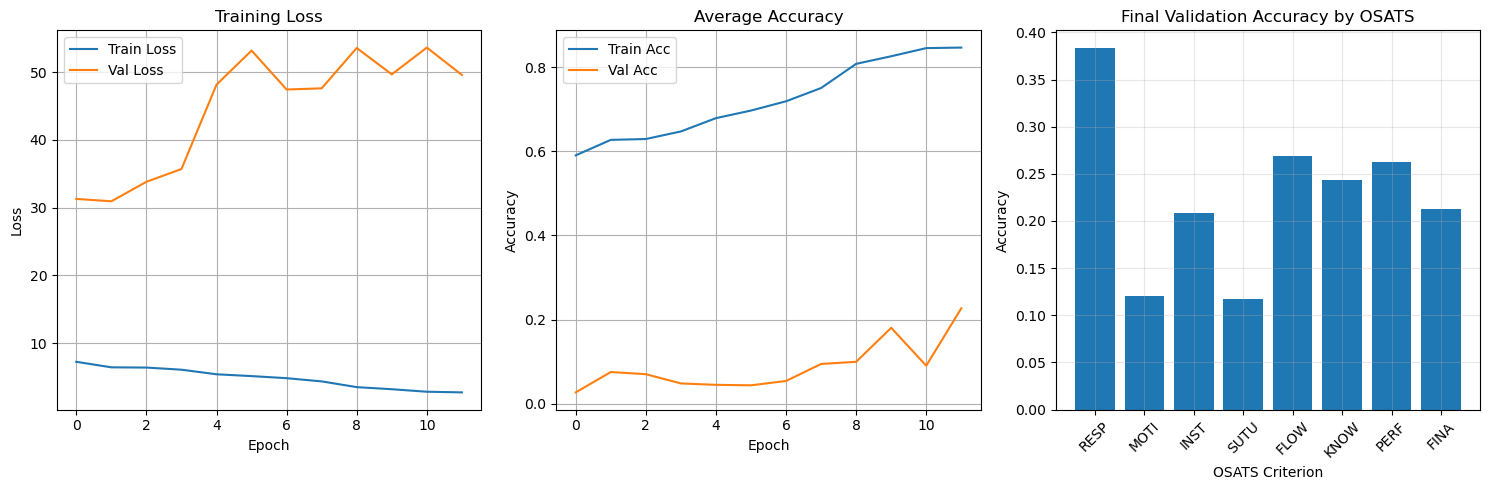

📊 Training visualization saved to: ../results/task2_training_curves.png


In [30]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
train_acc_avg = [np.mean(acc) for acc in train_accuracies]
val_acc_avg = [np.mean(acc) for acc in val_accuracies]
plt.plot(train_acc_avg, label='Train Acc')
plt.plot(val_acc_avg, label='Val Acc')
plt.title('Average Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
final_val_acc = val_accuracies[-1] if val_accuracies else [0] * CONFIG['num_osats']
plt.bar(range(CONFIG['num_osats']), final_val_acc)
plt.title('Final Validation Accuracy by OSATS')
plt.xlabel('OSATS Criterion')
plt.ylabel('Accuracy')
plt.xticks(range(CONFIG['num_osats']), 
          [c[:4] for c in OSATS_CRITERIA], rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/task2_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Training visualization saved to: ../results/task2_training_curves.png")